# Table of Contents
---
- [Setup](#Setup)
- [Embedding Table](#Embedding-Table)
- [Hidden Layer](#Hidden-Layer)
    - [Tensor operations](#Tensor-operations)
- [Output Layer](#Output-Layer)
- [Parameter List](#Parameter-List)
- [Cross Entropy](#Cross-Entropy)
- [Minibatch Gradient Descent](#Minibatch-Gradient-Descent)
- [Learning Rate](#Learning-Rate)
- [Scaling the Network](#Scaling-the-Network)
    - [Parameter Initialization](#Parameter-Initialization)
    - [Model-Training](#Model-Training)
    - [Model-Validation](#Model-Validation)
    - [Sampling](#Sampling)
- [References](#References)

# Setup

In [132]:
import torch
import torch.nn.functional as F

import random
import matplotlib.pyplot as plt
%matplotlib inline

In [135]:
# load data
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [136]:
# create vocabulary of characters
chars = sorted(list(set(''.join(words))))
c2i = {c:i+1 for i, c in enumerate(chars)}
c2i['.'] = 0
i2c = {i:c for c, i in c2i.items()}
print(i2c)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [137]:
def build_dataset(words):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            idx = c2i[ch]
            X.append(context)
            y.append(idx)
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y

In [138]:
# Train Dev Test split
random.seed(42)
random.shuffle(words)
X, y = build_dataset(words)
train_idx = int(len(words) * 0.8)
test_idx = int(len(words)*0.9)
X_train, y_train = build_dataset(words[:train_idx])
X_dev, y_dev = build_dataset(words[train_idx : test_idx])
X_test, y_test = build_dataset(words[test_idx:])

In [141]:
print(f"X: {X.shape}  y: {y.shape}\n")
print(f"X_train: {X_train.shape}  y_train: {y_train.shape}\n")
print(f"X_dev: {X_dev.shape}  y_dev: {y_dev.shape}\n")
print(f"X_test: {X_test.shape}  y_test: {y_test.shape}\n")

X: torch.Size([228146, 3])  y: torch.Size([228146])

X_train: torch.Size([182625, 3])  y_train: torch.Size([182625])

X_dev: torch.Size([22655, 3])  y_dev: torch.Size([22655])

X_test: torch.Size([22866, 3])  y_test: torch.Size([22866])



# Embedding Table

In [34]:
C = torch.randn((27,2))
C.shape

torch.Size([27, 2])

In [35]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

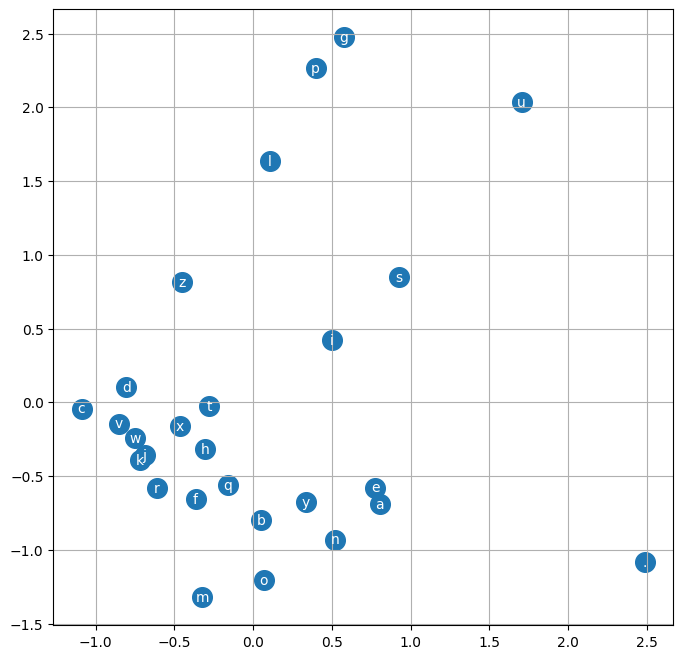

In [143]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), i2c[i], ha="center", va="center", color='white')
plt.grid('minor')

# Hidden Layer
---
- The shape of the hidden layer depends on:
    - The size and number of embeddings.
    - The number of neurons required in the hidden layer.

In [36]:
# init weights and biases
# no. of neurons => 100
w1 = torch.randn((6, 100))
b1 = torch.randn(100)
w1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

## Tensor operations
---
- `torch.cat(tensors, dim=0, *)`
    - concatenates the given sequences of tensors in the given dimension.
    - all tensors must have the same shape or be empty.
    - creates a new tensor with allocated memory.
    - **Refer** : [torch.cat()](https://pytorch.org/docs/stable/generated/torch.cat.html)
    ---
- `torch.unbind(input, dim=0)`
    - returns a tuple of all slices along a given dimension, already without it.
    - **Refer** : [torch.unbind()](https://pytorch.org/docs/stable/generated/torch.unbind.html)
    ---
- `Tensor.storage()`
    - returns the underlying `TypedStorage`.
    - **Refer** : [Tensor.storage()](https://pytorch.org/docs/stable/generated/torch.Tensor.storage.html)
    ---
- `Tensor.view(*shape)`
    - returns a new tensor with same data as `self` tensor but with different shape.
    - enables changing shape of a tensor without in-memory operations.
    - **Refer** : [Tensor.view()](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)
---
For more info on PyTorch internal workings, refer : **[PyTorch Internals](http://blog.ezyang.com/2019/05/pytorch-internals/)**

In [39]:
# 3 methods of torch operations

# 1.Naive method
print(torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape)

# 2. Optimized
print(torch.cat(torch.unbind(emb, 1), 1).shape)

# 3. Best
print(emb.view(emb.shape[0],6).shape)

torch.Size([228146, 6])
torch.Size([228146, 6])
torch.Size([228146, 6])


In [40]:
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
print(h.shape)
h

torch.Size([228146, 100])


tensor([[ 0.8004,  0.6712,  0.1469,  ..., -0.8923, -0.0201, -0.3575],
        [ 0.8868,  0.8237, -0.1074,  ..., -0.8776, -0.2545, -0.3666],
        [ 0.9964,  0.9998, -0.8540,  ..., -0.9912, -0.8291, -0.9883],
        ...,
        [ 0.9328, -0.9457, -0.7113,  ..., -0.7574, -0.2544,  0.9660],
        [ 0.5250,  0.9117,  0.9147,  ..., -0.9709,  0.8410,  0.2632],
        [ 0.9472, -0.9755, -0.9997,  ...,  0.6133, -0.9415,  0.9964]])

# Output Layer

In [41]:
w2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [42]:
logits = h @ w2 + b2
logits.shape

torch.Size([228146, 27])

In [43]:
log_counts = logits.exp()
prob = log_counts / log_counts.sum(1, keepdims=True)
prob.shape, prob[0].sum()

(torch.Size([228146, 27]), tensor(1.0000))

In [44]:
# initial network probabilities
prob[torch.arange(32), y]

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [45]:
loss = -prob[torch.arange(32), y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

# Parameter List
---
- `C` : character embedding table
- `w1`, `b1` : weights, biases of hidden layer `h`
- `w2`, `b2` : weights, biases of output layer

In [100]:
X.shape, y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [174]:
seed = 2147483647
gen = torch.Generator().manual_seed(seed)
C = torch.randn((27,2), generator=gen)
w1 = torch.randn((6,100), generator=gen)
b1 = torch.randn(100, generator=gen)
w2 = torch.randn((100, 27), generator=gen)
b2 = torch.randn(27, generator=gen)
parameters = [C, w1, b1, w2, b2]

In [175]:
sum(p.nelement() for p in parameters)

3481

In [176]:
for p in parameters:
    p.requires_grad = True

# Cross Entropy
---
- Instead of the following lines of code:
    ```python
    log_counts = logits.exp()
    probs = log_counts / log_counts.sum(1, keepdims=True)
    loss = -prob[torch.arange(32), y].log().mean()
    ```
    we can implement `F.cross_entropy(logits, y)`.
- Further, `torch.exp()` can explode when given large positive numbers. `F.cross_entropy()` resolves this internally by element-wise subtraction of the largest value of the logits, such that the largest value in the logits is then 0.
---
**Refer** : [F.cross_entropy()](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html)

In [51]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y)
loss

tensor(19.5052)

# Minibatch Gradient Descent
---
- Instead of iterating over the entire dataset in each step, we can iterate over batches/ mini-batches of the dataset, thereby taking smaller steps of gradient descent.
- This leads to a quicker but noisier model convergence as shown below.
---
[init data](#Summary)

In [167]:
n_epochs = 25
lr = 0.1
losses = []
steps = []

In [168]:
# re-init training parameters before running this cell

for epoch in range(n_epochs):
    # minibatch indices
    idx = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[idx]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y[idx])
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    for p in parameters:
        p.data += -lr*p.grad
    
    # track stats
    losses.append(loss.item())
    steps.append(epoch)

19.7116756439209
17.807748794555664
17.155527114868164
15.474634170532227
13.32128620147705
10.765377044677734
14.61640739440918
14.277920722961426
10.310137748718262
10.69010066986084
9.726461410522461
10.607566833496094
11.147387504577637
9.527170181274414
11.207534790039062
7.228404521942139
9.334579467773438
8.84821891784668
11.24681282043457
7.5291595458984375
10.099346160888672
10.465667724609375
8.120137214660645
7.756718635559082
9.541410446166992


Text(0, 0.5, 'No. of steps')

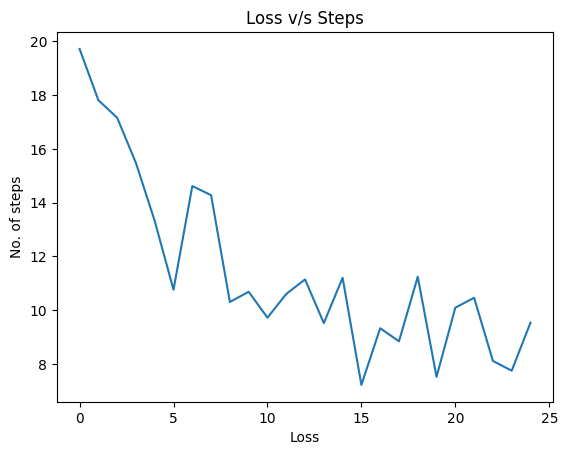

In [171]:
plt.plot(steps, losses)
plt.title("Loss v/s Steps")
plt.xlabel("Loss")
plt.ylabel("No. of steps")

# Learning Rate
---
- Here, we create a list of learning rates which lie within a specific range on the logarithmic scale.
- While training, each epoch sequentially uses these learning rates, starting from very low to very high values as training proceeds.
---
[init data](#Summary)

In [177]:
lre = torch.linspace(-3, 0, 1000)  # exponents
lrs = 10**lre  # values
lre[:50],lrs[:50]

(tensor([-3.0000, -2.9970, -2.9940, -2.9910, -2.9880, -2.9850, -2.9820, -2.9790,
         -2.9760, -2.9730, -2.9700, -2.9670, -2.9640, -2.9610, -2.9580, -2.9550,
         -2.9520, -2.9489, -2.9459, -2.9429, -2.9399, -2.9369, -2.9339, -2.9309,
         -2.9279, -2.9249, -2.9219, -2.9189, -2.9159, -2.9129, -2.9099, -2.9069,
         -2.9039, -2.9009, -2.8979, -2.8949, -2.8919, -2.8889, -2.8859, -2.8829,
         -2.8799, -2.8769, -2.8739, -2.8709, -2.8679, -2.8649, -2.8619, -2.8589,
         -2.8559, -2.8529]),
 tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
         0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
         0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
         0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
         0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
         0.0014, 0.0014, 0.0014, 0.0014, 0.0014]))

In [178]:
# re-init parameters before running this cell
lre_stats = []
loss_stats = []
lr_stats = []

n_epochs = 1000
for epoch in range(n_epochs):
    # minibatch indices
    idx = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[idx]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y[idx])
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    lr = lrs[epoch]
    for p in parameters:
        p.data += -lr*p.grad
        
    # track stats
    lr_stats.append(lr)
    lre_stats.append(lre[epoch])
    loss_stats.append(loss.item())

Text(0, 0.5, 'Loss')

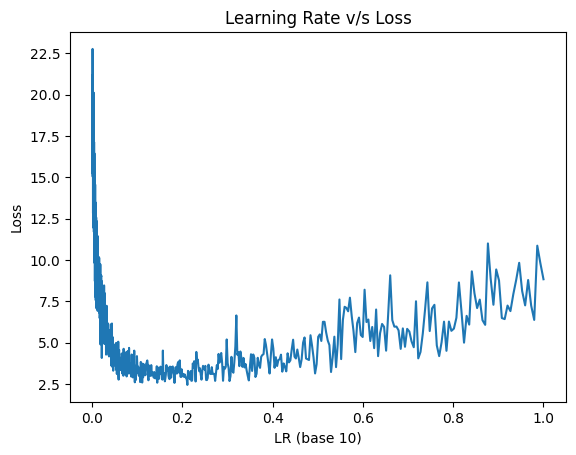

In [179]:
plt.plot(lr_stats, loss_stats)
plt.title("Learning Rate v/s Loss")
plt.xlabel("LR (base 10)")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

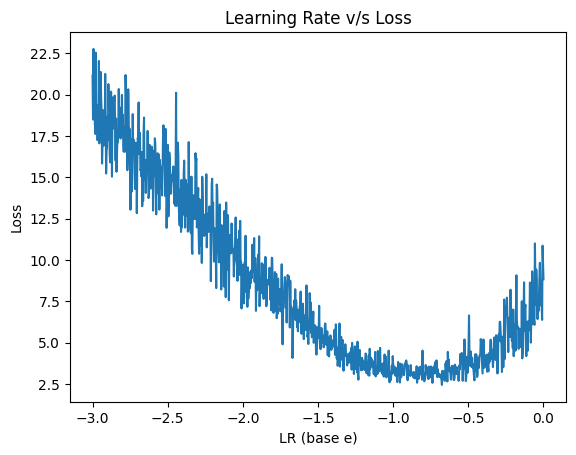

In [180]:
plt.plot(lre_stats, loss_stats)
plt.title("Learning Rate v/s Loss")
plt.xlabel("LR (base e)")
plt.ylabel("Loss")

# Scaling the Network
---
- Increase the number of neurons in the hidden layer from 100 to 200.
- Increase the Embedding dimensions from (27,2) => (27,10)
- Implement a rudimentary form of learning rate decay after specified number of steps.
- Check model loss on train and test splits.

## Parameter Initialization

In [148]:
block_size = 3

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
w1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
w2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

In [149]:
sum(p.nelement() for p in parameters)

11897

In [150]:
for p in parameters:
    p.requires_grad = True

In [152]:
loss_stats = []
step_stats = []

## Model Training

In [153]:
for i in range(200000):
    # minibatch indices
    idx = torch.randint(0, X_train.shape[0], (32,))

    # forward pass
    emb = C[X_train[idx]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # (32, 200)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, y_train[idx])
    #print(loss.item())

    # backward pass
    for p in parameters:
    p.grad = None
    loss.backward()

    # update parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
    p.data += -lr * p.grad

    # track stats
    step_stats.append(i)
    loss_stats.append(loss.log10().item())

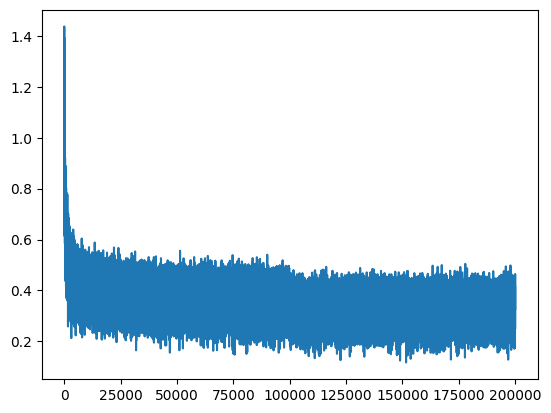

In [155]:
plt.plot(step_stats, loss_stats)

## Model Validation

In [156]:
# training loss
emb = C[X_train] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # (32, 100)
logits = h @ w2 + b2 # (32, 27)
loss = F.cross_entropy(logits, y_train)
loss

tensor(2.1244, grad_fn=<NllLossBackward0>)

In [157]:
emb = C[X_dev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # (32, 100)
logits = h @ w2 + b2 # (32, 27)
loss = F.cross_entropy(logits, y_dev)
loss

tensor(2.1626, grad_fn=<NllLossBackward0>)

## Sampling

In [163]:
# sample from the model
gen = torch.Generator().manual_seed(13)

for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=gen).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
        break

    print(''.join(i2c[i] for i in out))

lain.
joh.
orazon.
pelothaloer.
ily.
jobora.
jaro.
darrick.
loryn.
rhouilama.
delylle.
marageecaria.
anyalysis.
demancarisha.
jabbeiadia.
sriw.
yith.
kei.
bre.
tashermanelianya.


# References
---
- [YouTube](https://www.youtube.com/watch?v=TCH_1BHY58I&t=569s)
- [GitHub](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb)